## Data Analysis

In [1]:
# import needed libraries
import matplotlib.pyplot as plt
import matplotlib.style as style
import pandas as pd
import numpy as np
import wfdb
import ast
import seaborn as sns

In [2]:
# loading data and visualization data
def load_raw_data(df, sampling_rate):
    if sampling_rate == 100:
        data = [wfdb.rdsamp(f) for f in df.filename_lr]
    else:
        data = [wfdb.rdsamp(f) for f in df.filename_hr]
    data = np.array([signal for signal, meta in data])
    return data

sampling_rate=100

# load and convert annotation data
Y = pd.read_csv('ptbxl_database.csv', index_col='ecg_id')
Y.scp_codes = Y.scp_codes.apply(lambda x: ast.literal_eval(x))

# Load raw signal data
X = load_raw_data(Y, sampling_rate)

# Load scp_statements.csv for diagnostic aggregation
#agg_df = pd.read_csv(path+'scp_statements.csv', index_col=0)
agg_df = pd.read_csv('scp_statements.csv', index_col=0)
agg_df = agg_df[agg_df.diagnostic == 1]

def aggregate_diagnostic(y_dic):
    tmp = []
    for key in y_dic.keys():
        if key in agg_df.index:
            tmp.append(agg_df.loc[key].diagnostic_class)
    return list(set(tmp))

# Apply diagnostic superclass
Y['diagnostic_superclass'] = Y.scp_codes.apply(aggregate_diagnostic)

# remove spaces and squared brackets from data 
Y['diagnostic_superclass']= Y['diagnostic_superclass'].astype(str).str.replace(' ', '')
Y['diagnostic_superclass'] = Y['diagnostic_superclass'].astype(str).str.replace(r'\[|\]|','')



C:\Users\rebec\AppData\Local\Temp\ipykernel_5600\1489677276.py:36: FutureWarning: The default value of regex will change from True to False in a future version.
  Y['diagnostic_superclass'] = Y['diagnostic_superclass'].astype(str).str.replace(r'\[|\]|','')


In [3]:
# Split data into train and test
test_fold = 10
# Train
X_train = X[np.where(Y.strat_fold != test_fold)]
y_train = Y[(Y.strat_fold != test_fold)].diagnostic_superclass
# Test
X_test = X[np.where(Y.strat_fold == test_fold)]
y_test = Y[Y.strat_fold == test_fold].diagnostic_superclass

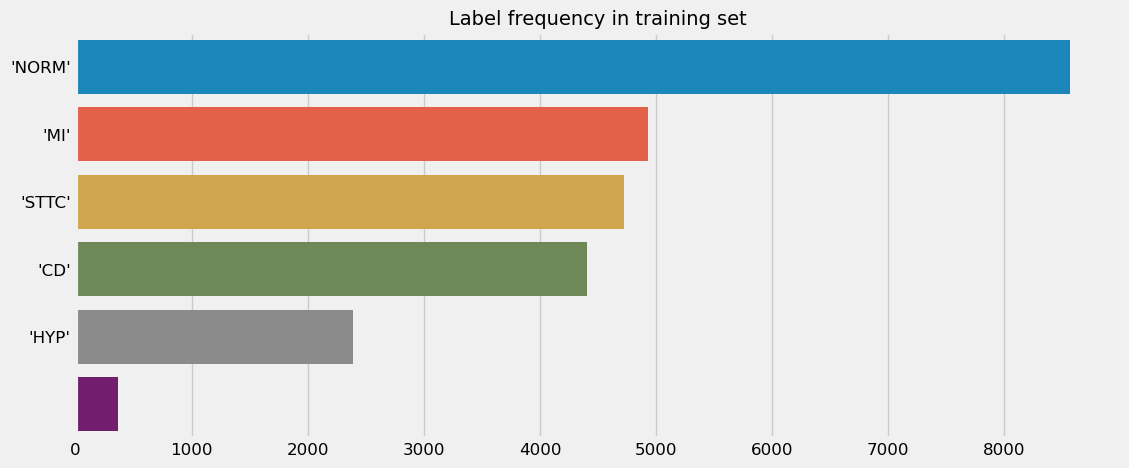

In [4]:
# visualization of label distribution in the training set 
label_freq_train = y_train.apply(lambda s: str(s).split(',')).explode().value_counts().sort_values(ascending=False)

# Bar plot
style.use("fivethirtyeight")
plt.figure(figsize=(12,5))
sns.barplot(y=label_freq_train.index.values, x=label_freq_train, order=label_freq_train.index)
plt.title("Label frequency in training set", fontsize=14)
plt.xlabel("")
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()


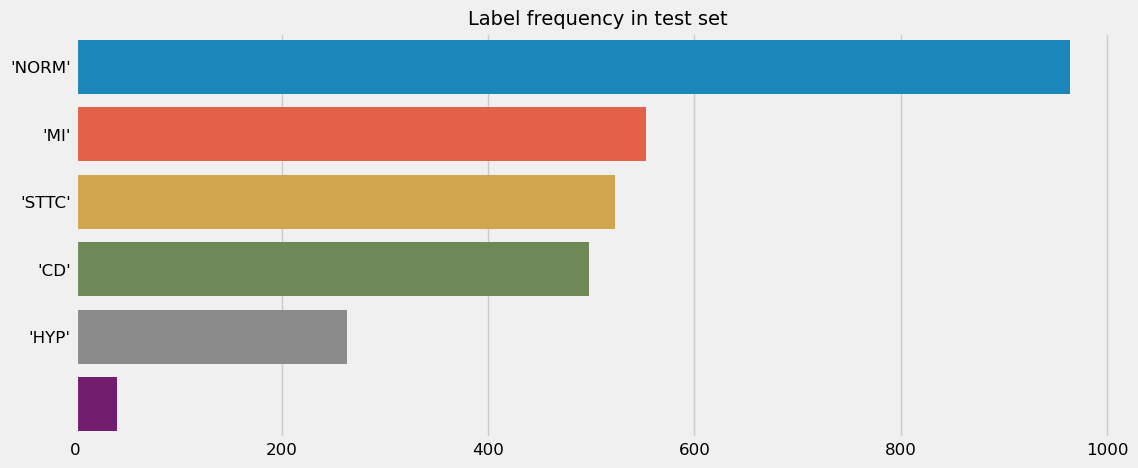

In [5]:
# visualization of label distribution in the test set 
label_freq_test = y_test.apply(lambda s: str(s).split(',')).explode().value_counts().sort_values(ascending=False)

# Bar plot
style.use("fivethirtyeight")
plt.figure(figsize=(12,5))
sns.barplot(y=label_freq_test.index.values, x=label_freq_test, order=label_freq_test.index)
plt.title("Label frequency in test set", fontsize=14)
plt.xlabel("")
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

## Data cleaning 
From the charts above, it is possible to notice that there are unlabelled data (367 elements of the training set and 40 elements in the test set). These elements are not usefull for the network to learn and for this reason they will be removed in the data cleaning phase. After that step our training set will be caracterized by 19267 elements while the testing set by 2163 elements. The proportions between the number of elements in the training set and in the testing set remains the same as before (90% - 10%). 

In [6]:
# our data have been divided between training and validation
# The index of the y_train and y_test comes from the split and belongs to 
# the original dataset --> reset indices to being able to remove the same 
# rows from the x dataset
y_train_ri = y_train.reset_index(drop=True)
y_test_ri = y_test.reset_index(drop=True)
index2remove_train = (y_train_ri[y_train_ri ==''].index.values)
index2remove_test = (y_test_ri[y_test_ri ==''].index.values)
y_train_cl = y_train_ri.drop(index=index2remove_train)
y_test_cl = y_test_ri.drop(index=index2remove_test)
X_train_cl = np.delete(X_train, index2remove_train,0)
X_test_cl = np.delete(X_test, index2remove_test,0)

# reset indices again since we removed rows 
y_train_clri = y_train_cl.reset_index(drop=True)
y_test_clri = y_test_cl.reset_index(drop=True)

# conversion of data to a list 
y_train_list = y_train_clri.apply(lambda s: [l for l in str(s).split(',')])
y_test_list = y_test_clri.apply(lambda s: [l for l in str(s).split(',')])

## Label Encoding

In [7]:
from sklearn.preprocessing import MultiLabelBinarizer
print("Labels:")
mlb = MultiLabelBinarizer()
mlb.fit(y_train_list)

# Numerical label associated with each categorical label
N_LABELS = len(mlb.classes_)
class_names = []
for (i, label) in enumerate(mlb.classes_):
    print("{}. {}".format(i, label))
    class_names.append(label)

Labels:
0. 'CD'
1. 'HYP'
2. 'MI'
3. 'NORM'
4. 'STTC'


In [8]:
# transform the targets of the training and test sets through hot encoding 
y_train_bin = mlb.transform(y_train_list)
y_test_bin = mlb.transform(y_test_list)
#to check the correctness of the transformation
#for i in range(100):
#    print(i, y_train_clri[i], y_train_bin[i])

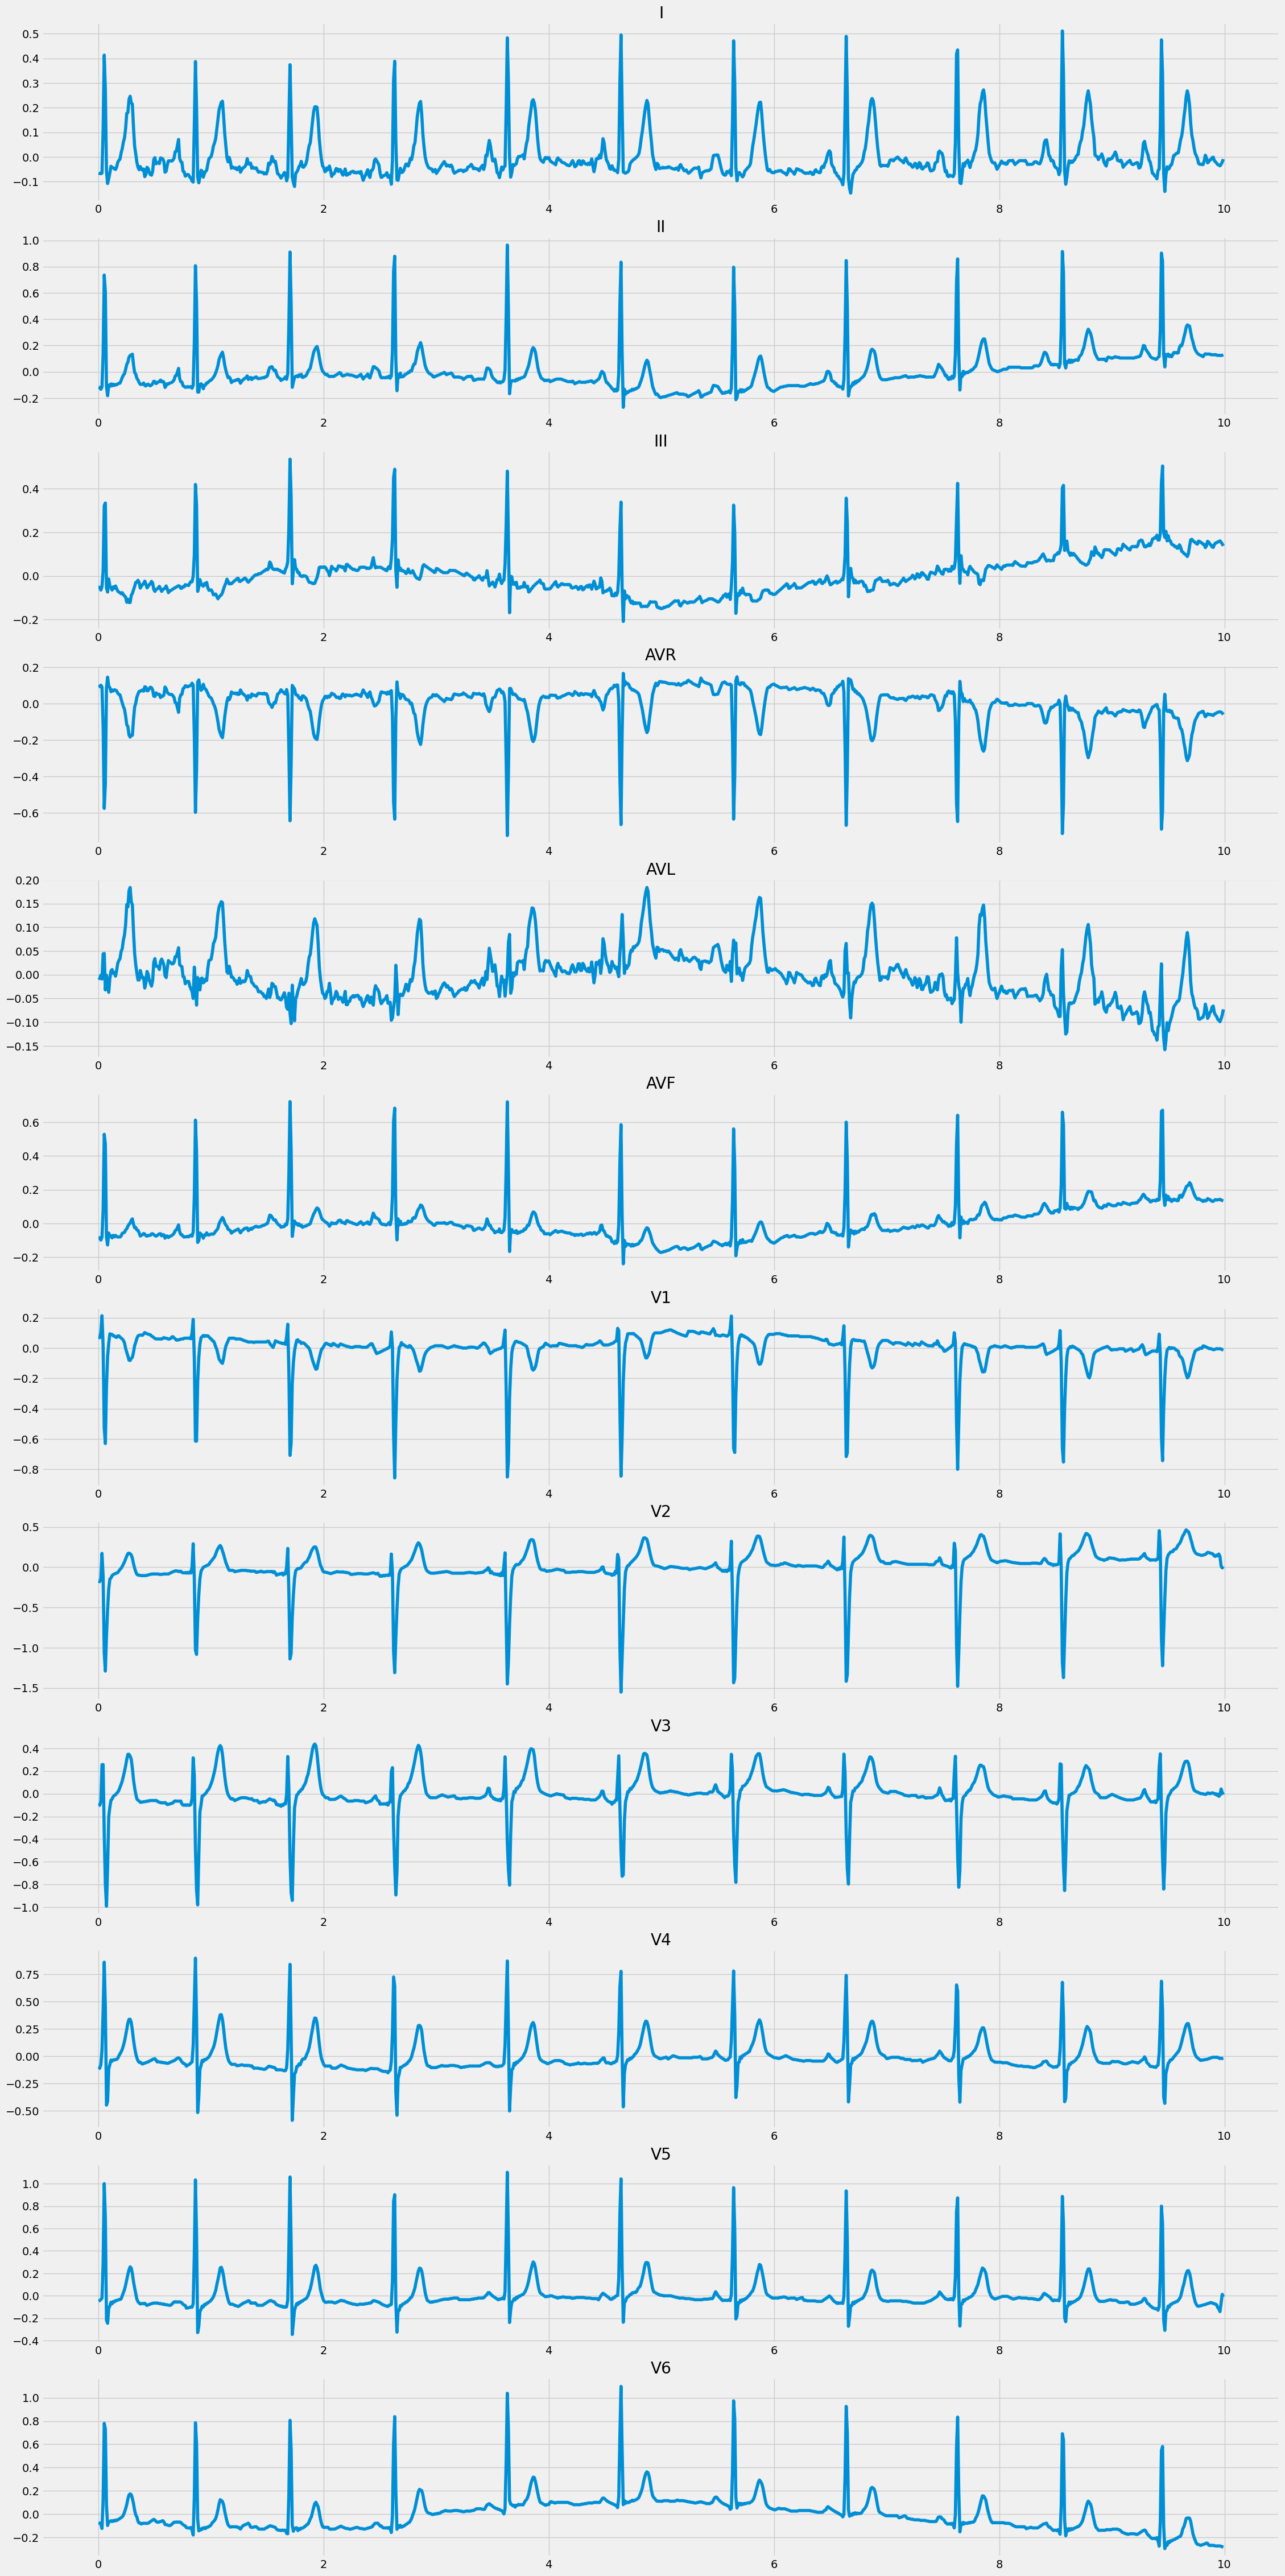

In [9]:
# let's print some example to become familiar with data: 
def visualize_ECG(X, n_row, sampling_rate = 100):
    '''
    function to visualize the ECG in all the 12 derivations
    '''
    i,j=0,0
    PLOTS_PER_ROW = 1
    NUM_COLUMNS = 12
    # time axis according with the sampling rate
    t = np.linspace(0,10-1/sampling_rate, num = 1000); 
    sample_start = 0; 
    sample_end = 1000;
    der = ['I', 'II', 'III', 'AVR', 'AVL', 'AVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']
    fig, axs = plt.subplots(NUM_COLUMNS, PLOTS_PER_ROW, figsize=(25, 55), squeeze = False)
    for col in range (NUM_COLUMNS):
        axs[col][0].plot(t[sample_start:sample_end], X[n_row,sample_start:sample_end,col])
        title = der[col]
        axs[i][j].set_title(title)
        j+=1
        if j%PLOTS_PER_ROW==0:
            i+=1
            j=0
    plt.show()
    pass

visualize_ECG(X_train_cl, 8)


## Data Normalization

In [10]:
def Min_Max_Scaling(X): 
    num_row = X.shape[0]
    max_value = []
    min_value =[]
    for i in range(num_row):
        max_value.append(np.max(X[i,:,:]))
        min_value.append(np.min(X[i,:,:]))
        
    # initialize a new matrix
    X_norm = np.zeros(X.shape)
    for i in range(num_row):
        X_norm[i,:,:] = (X[i,:,:]-min_value[i])/(max_value[i]-min_value[i])
    
    return X_norm

In [11]:
X_train_norm = Min_Max_Scaling(X_train_cl)
X_test_norm = Min_Max_Scaling(X_test_cl)

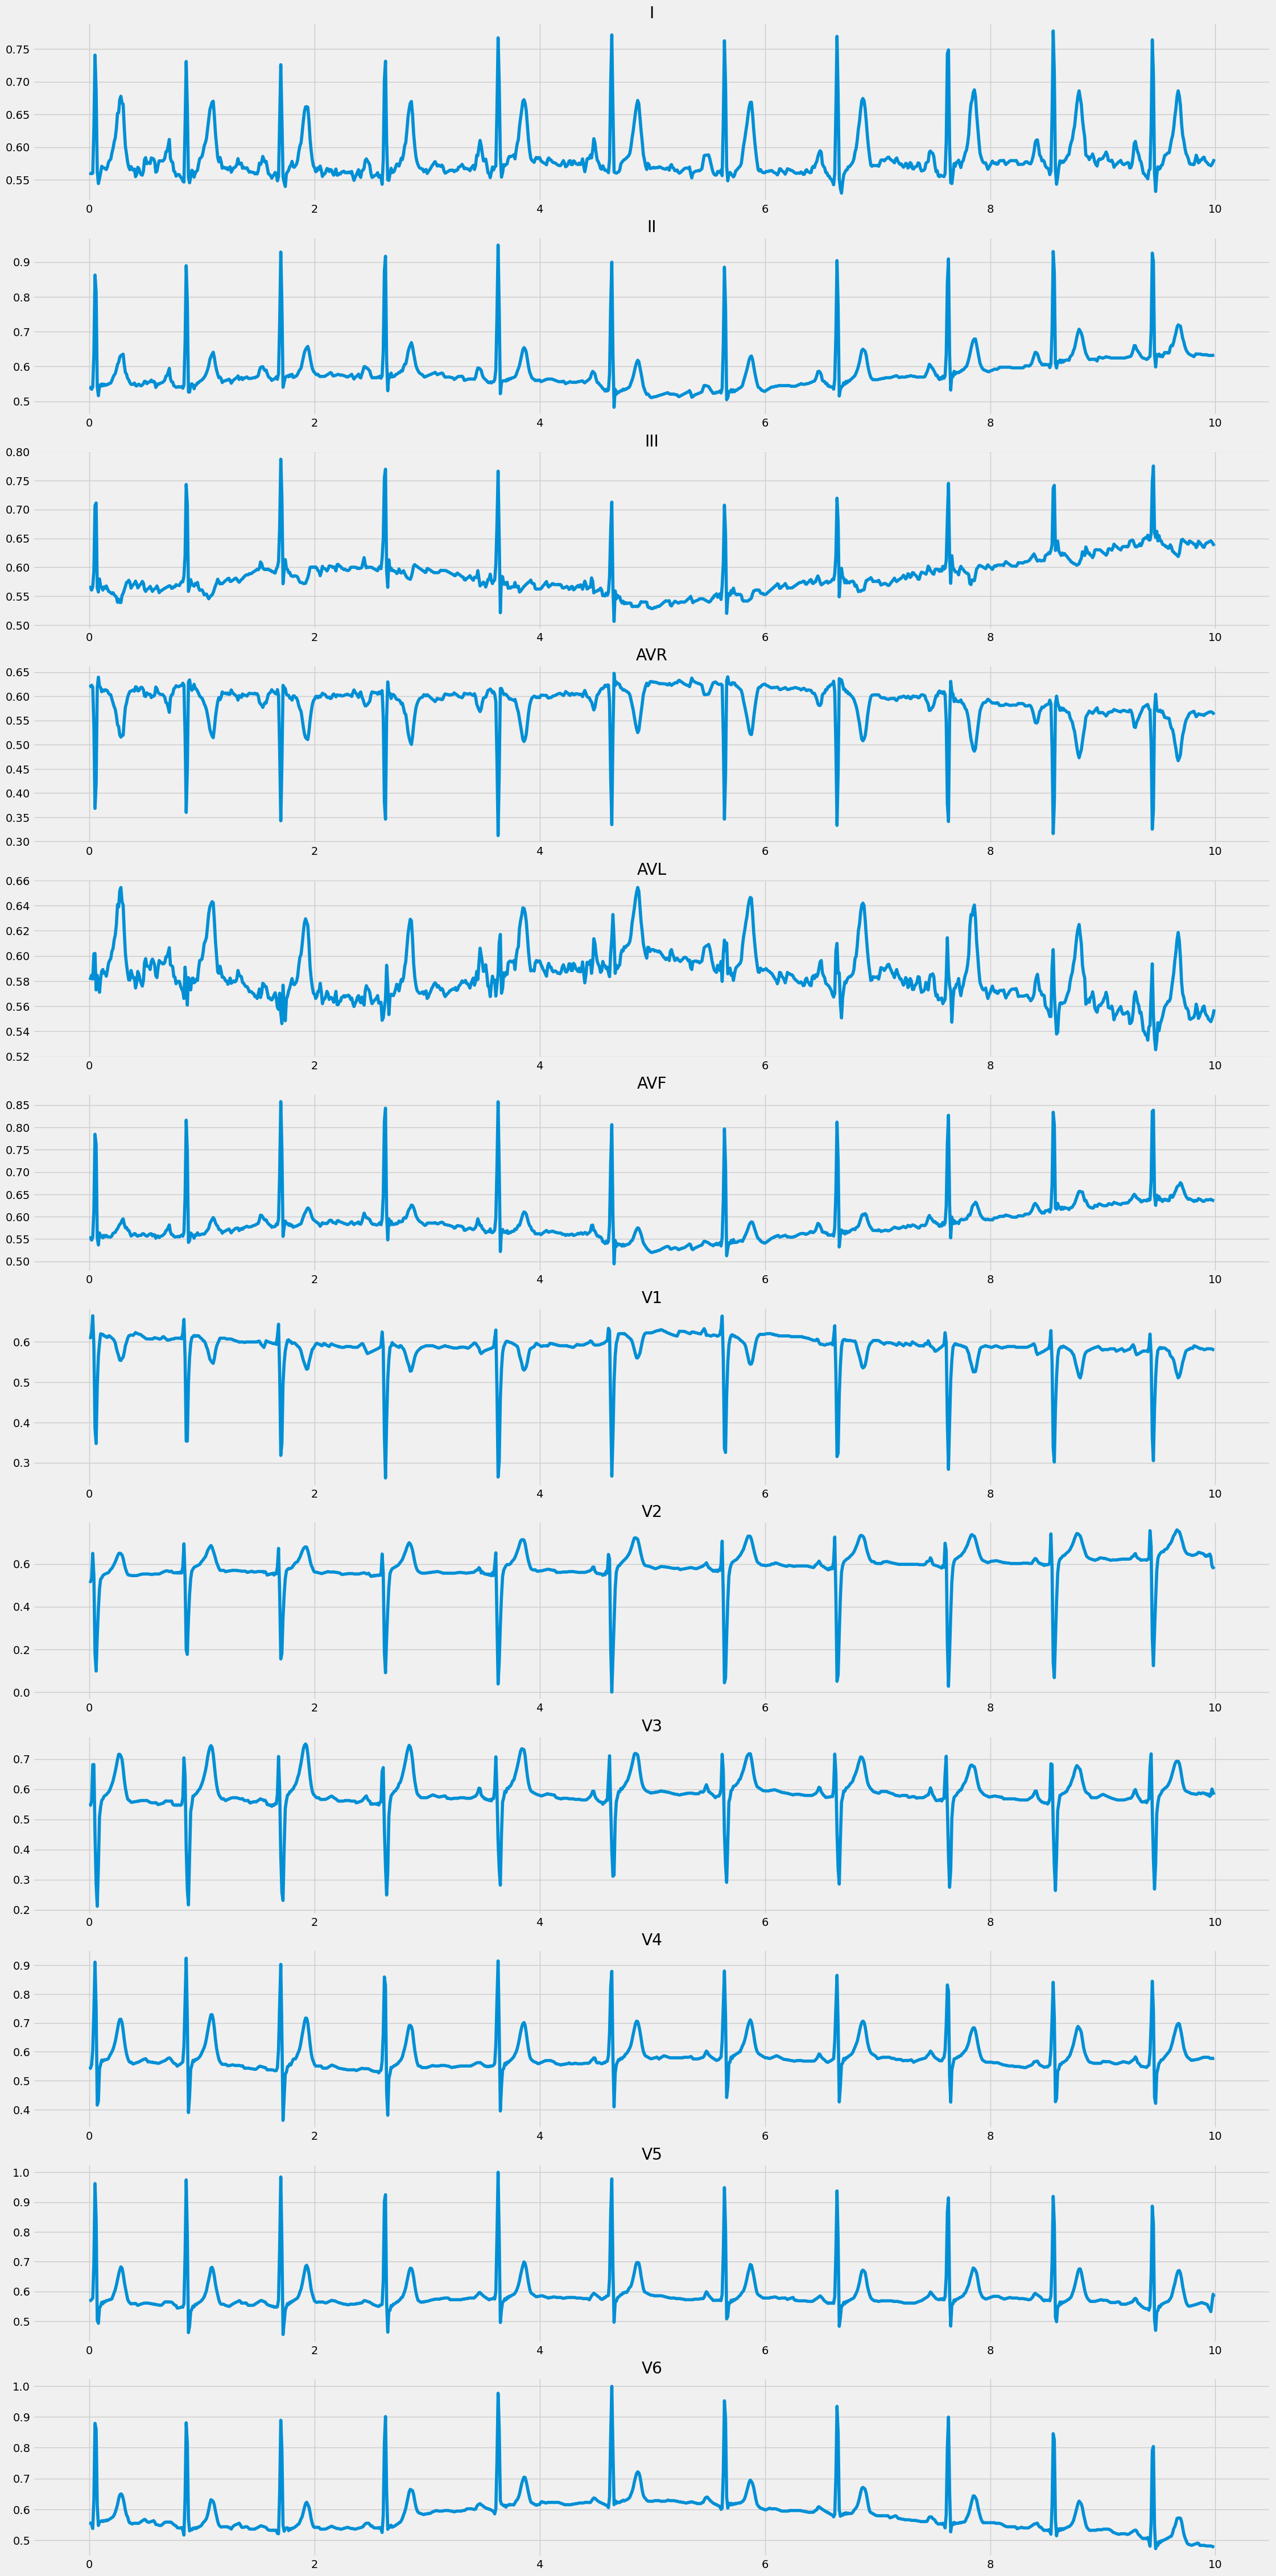

In [12]:
visualize_ECG(X_train_norm, 8)

## Class Imbalance

For multi label classification, a way to avoid the problem of class imbalance consists in assigning a weight for each sample in the training set. The weight for each sample can then be computed as inversely proportional to the respective class frequence. In the multilabel case the weight could be chosen, e.g., as the mean or the maximum value of the weights of all classes attributed to a given sample. The following function computes weights as floats between 0 and 1 inversely proportional to the frequency of a given class. If multiple labels appear in a sample, the maximum weight is returned.

http://fmnt.info/blog/20201029_sample-weights.html

NOT USED IN THE FIT FUNCTION

In [13]:
from collections import Counter

def get_sample_weight(y):
    """Return sample weights. For each sample take the maximum weight
    of the respective labels.
    """
    y = np.asarray(y)
    class_count = Counter(np.concatenate([np.where(a == 1)[0] for a in y]))
    min_count = min(class_count.values())
    class_weight = {}
    for key, val in class_count.items():
        class_weight[key] = min_count / val
    sample_weight = []
    for label in y:
        idx, *__ = np.where(label == 1)
        sample_weight += [max([class_weight[i] for i in idx])]
    return np.array(sample_weight)

# Synthetic data.
y = [[1, 1, 0], [1, 0, 1], [1, 0, 0], [0, 1, 0], [1, 1, 0]]

# Sample weights
sample_weight = get_sample_weight(y_train_bin)   
print(sample_weight)

[0.27930873 0.27930873 0.27930873 ... 0.50602919 0.27930873 0.27930873]


# Model

In [14]:
import tensorflow as tf
from tensorflow import keras
from keras import Sequential, Model, metrics
from tensorflow.keras.layers import Dense, Input, LSTM, Dropout, Flatten
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Activation, BatchNormalization, SpatialDropout1D, Attention, RepeatVector
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Bidirectional 
from tensorflow.keras.layers import Concatenate
from keras.regularizers import l2
from keras.layers import *
from keras.models import *
from keras import backend as K
from tensorflow_addons.metrics import HammingLoss, F1Score
from tensorflow.keras.metrics import FalsePositives, FalseNegatives, Recall, Precision
from sklearn.metrics import accuracy_score, multilabel_confusion_matrix, classification_report, precision_score, recall_score, hamming_loss
# visualization of the network
#!pip install git+https://github.com/paulgavrikov/visualkeras --upgrade
import tensorflow_addons as tfa
import visualkeras
from PIL import ImageFont




In [17]:
def Model4(signal_channel, signal_dim, filters_convolutional, filters_lstm, filters_dense, number_class): 
    
    model = Sequential()
    
    
    model.add(Conv1D(filters=filters_convolutional, input_shape=(signal_dim, signal_channel),kernel_size= 10, strides=2, padding='same'))
    model.add(Dropout(0.2))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))
    
    
    model.add(Conv1D(filters=filters_convolutional, kernel_size= 5, strides=2, padding='same'))
    model.add(Dropout(0.2))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))
    
    model.add(Bidirectional(LSTM(filters_lstm, return_sequences = True, recurrent_dropout=0.2)))
    model.add(Bidirectional(LSTM(int(filters_lstm/2))))
    
    model.add(Dense(filters_dense))
    model.add(Activation('relu'))
    model.add(Dropout(0.4))
    model.add(BatchNormalization())
    
    model.add(Dense(int(filters_dense/2)))
    model.add(Activation('relu'))
    model.add(Dropout(0.4))
    model.add(BatchNormalization())
    
    model.add(Dense(number_class))
    # sigmoid because of multi label classification --> important to check this thing 
    # the sigmoid at the last layer will output the probability score for each label apart. 
    model.add(Activation('sigmoid'))
    
    model.summary()
    
    return model
    
     
    

In [18]:
number_class = 5
optimizer = Adam
filters_convolutional = 64
filters_lstm = 32
filters_dense = 128
lr = 1e-4
batch_size = 32
signal_channel= np.shape(X_train_cl)[2]
signal_dimension = np.shape(X_train_cl)[1]
input_shape = (signal_dimension, signal_channel)
mymodel = Model4(signal_channel, signal_dimension, filters_convolutional, filters_lstm, filters_dense, number_class)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 500, 64)           7744      
                                                                 
 dropout (Dropout)           (None, 500, 64)           0         
                                                                 
 activation (Activation)     (None, 500, 64)           0         
                                                                 
 batch_normalization (BatchN  (None, 500, 64)          256       
 ormalization)                                                   
                                                                 
 max_pooling1d (MaxPooling1D  (None, 250, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 125, 64)           2

In [19]:
mymodel.compile(
    optimizer=optimizer(learning_rate = lr),
    loss = BinaryCrossentropy(),
    metrics = [HammingLoss(mode = 'multilabel', threshold = 0.5), 'accuracy', Recall(thresholds = 0.5, name = 'Recall'), Precision(thresholds = 0.5, name = 'Precision'), F1Score(num_classes = 5, average = 'macro', threshold = 0.5)]
)

In [20]:
checkpoint_filepath = './checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath = checkpoint_filepath,
    save_weights_only = True,
    monitor = 'val_hamming_loss',
    mode = 'min',
    save_best_only = True)

mymodel_hist = mymodel.fit(X_train_norm, y_train_bin, batch_size=batch_size, epochs = 150, verbose=1, validation_data=(X_test_norm, y_test_bin),  callbacks = [model_checkpoint_callback])
#sample_weight = sample_weight,

Epoch 1/150
Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
603/603 [==============================] - 88s 123ms/step - loss: 0.7966 - hamming_loss: 0.4661 - accuracy: 0.2170 - Recall: 0.4768 - Precision: 0.2728 - f1_score: 0.3596 - val_loss: 0.6817 - val_hamming_loss: 0.3841 - val_accuracy: 0.2113 - val_Recall: 0.2363 - val_Precision: 0.2473 - val_f1_score: 0.3179
Epoch 2/150
603/603 [==============================] - 77s 127ms/step - loss: 0.6969 - hamming_loss: 0.4001 - accuracy: 0.2639 - Recall: 0.4181 - Precision: 0.3038 - f1_score: 0.3686 - val_loss: 0.5738 - val_hamming_loss: 0.2644 - val_accuracy: 0.3167 - val_Recall: 0.1864 - val_Precision: 0.4733 - val_f1_score: 0.3032
Epoch 3/150
603/603 [==============================] - 74s 123ms/step - loss: 0.6054 - hamming_loss: 0.3138 - accuracy: 0.3689 - Recall: 0.4278 - Precision: 0.

Epoch 51/150
603/603 [==============================] - 74s 123ms/step - loss: 0.3160 - hamming_loss: 0.1278 - accuracy: 0.6720 - Recall: 0.6748 - Precision: 0.8020 - f1_score: 0.6768 - val_loss: 0.3402 - val_hamming_loss: 0.1381 - val_accuracy: 0.6311 - val_Recall: 0.6883 - val_Precision: 0.7564 - val_f1_score: 0.6761
Epoch 52/150
603/603 [==============================] - 76s 125ms/step - loss: 0.3179 - hamming_loss: 0.1299 - accuracy: 0.6667 - Recall: 0.6694 - Precision: 0.7981 - f1_score: 0.6743 - val_loss: 0.3520 - val_hamming_loss: 0.1367 - val_accuracy: 0.6426 - val_Recall: 0.6665 - val_Precision: 0.7744 - val_f1_score: 0.6605
Epoch 53/150
603/603 [==============================] - 75s 125ms/step - loss: 0.3169 - hamming_loss: 0.1279 - accuracy: 0.6701 - Recall: 0.6737 - Precision: 0.8022 - f1_score: 0.6786 - val_loss: 0.3372 - val_hamming_loss: 0.1393 - val_accuracy: 0.6329 - val_Recall: 0.6812 - val_Precision: 0.7565 - val_f1_score: 0.6681
Epoch 54/150
603/603 [===============

Epoch 102/150
603/603 [==============================] - 73s 122ms/step - loss: 0.2899 - hamming_loss: 0.1154 - accuracy: 0.6956 - Recall: 0.7128 - Precision: 0.8194 - f1_score: 0.7125 - val_loss: 0.3425 - val_hamming_loss: 0.1348 - val_accuracy: 0.6509 - val_Recall: 0.7158 - val_Precision: 0.7518 - val_f1_score: 0.6858
Epoch 103/150
603/603 [==============================] - 74s 123ms/step - loss: 0.2943 - hamming_loss: 0.1188 - accuracy: 0.6909 - Recall: 0.7019 - Precision: 0.8150 - f1_score: 0.7020 - val_loss: 0.3297 - val_hamming_loss: 0.1330 - val_accuracy: 0.6593 - val_Recall: 0.6937 - val_Precision: 0.7701 - val_f1_score: 0.6862
Epoch 104/150
603/603 [==============================] - 73s 122ms/step - loss: 0.2904 - hamming_loss: 0.1171 - accuracy: 0.6914 - Recall: 0.7084 - Precision: 0.8165 - f1_score: 0.7061 - val_loss: 0.3328 - val_hamming_loss: 0.1286 - val_accuracy: 0.6630 - val_Recall: 0.7076 - val_Precision: 0.7760 - val_f1_score: 0.6939
Epoch 105/150
603/603 [===========

In [23]:
print(np.min(mymodel_hist.history["val_loss"]))
print(np.max(mymodel_hist.history["val_accuracy"]))
print(np.min(mymodel_hist.history["val_hamming_loss"]))

0.3223815858364105
0.6865464448928833
0.12584373354911804


[Text(0.5, 0, 'Epochs'),
 Text(0.5, 0, 'Epochs'),
 Text(0.5, 0, 'Epochs'),
 Text(0.5, 0, 'Epochs'),
 Text(0.5, 0, 'Epochs'),
 Text(0.5, 0, 'Epochs')]

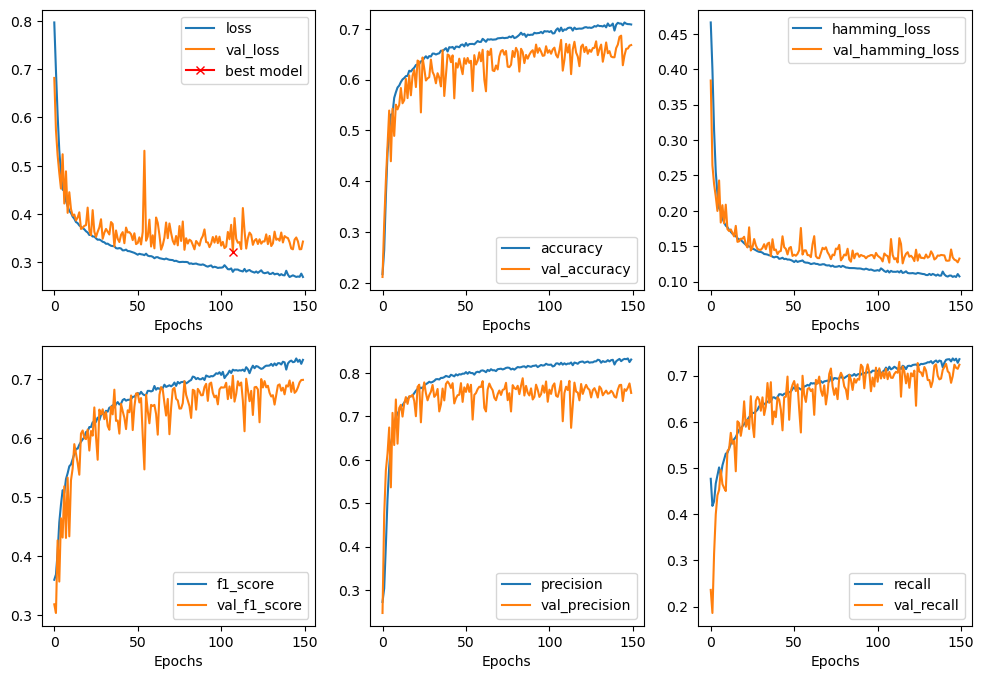

In [21]:
%matplotlib inline

style.use("default")
fig, axes = plt.subplots(2,3, figsize=(12,8))
axes[0][0].plot(mymodel_hist.history["loss"], label="loss")
axes[0][0].plot(mymodel_hist.history["val_loss"], label="val_loss")
axes[0][0].plot( np.argmin(mymodel_hist.history["val_loss"]),
       np.min(mymodel_hist.history["val_loss"]),
        marker="x", color="r", label="best model")
axes[0][0].legend();
#plt.xlabel("Epochs")

axes[0][1].plot(mymodel_hist.history["accuracy"], label="accuracy")
axes[0][1].plot(mymodel_hist.history["val_accuracy"], label="val_accuracy")
axes[0][1].legend();
#plt.xlabel("Epochs")

axes[0][2].plot(mymodel_hist.history["hamming_loss"], label="hamming_loss")
axes[0][2].plot(mymodel_hist.history["val_hamming_loss"], label="val_hamming_loss")
axes[0][2].legend();
#plt.xlabel("Epochs")

axes[1][0].plot(mymodel_hist.history["f1_score"], label="f1_score")
axes[1][0].plot(mymodel_hist.history["val_f1_score"], label="val_f1_score")
axes[1][0].legend();
#plt.xlabel("Epochs")

axes[1][1].plot(mymodel_hist.history["Precision"], label="precision")
axes[1][1].plot(mymodel_hist.history["val_Precision"], label="val_precision")
axes[1][1].legend();
#plt.xlabel("Epochs")

axes[1][2].plot(mymodel_hist.history["Recall"], label="recall")
axes[1][2].plot(mymodel_hist.history["val_Recall"], label="val_recall")
axes[1][2].legend();

plt.setp(axes[:], xlabel = "Epochs")

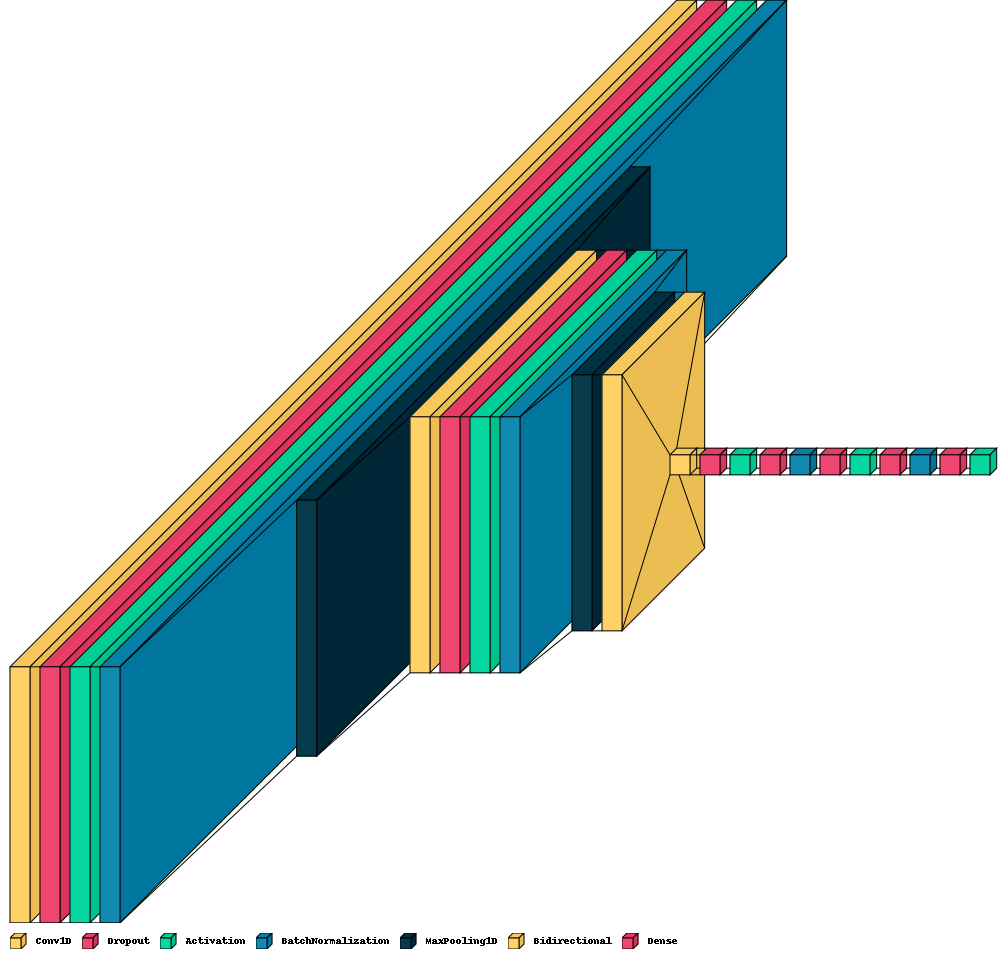

In [21]:
# just for visualizing the model --> figure in the assignemnt report
visualkeras.layered_view(mymodel, legend = True)

## Prediction 

How to use the model 

In [88]:
mymodel.load_weights(checkpoint_filepath)
y_pred = mymodel.predict(X_test_cl, verbose = 1)

68/68 [==============================] - 3s 33ms/step


In [ ]:
# apply a threshold
threshold = 0.5
y_pred[y_pred<threshold]=0
y_pred[y_pred>threshold]=1
# conversion in categorical label 
new_y_pred = mlb.inverse_transform(y_pred)
# print multilabel confusion matrix
#multilabel_confusion_matrix(y_test_bin, y_pred )

## Other model tested and tuned 

This model returned worst results. Consequently are not adopted as final network. 
1. CNN model 
2. Model2: LSTM model 
3. Model3: CNN and LSTM in parallel with concatenation of the results at the end 
4. Model_5: LSTM and then CNN 



In [ ]:
# tutta da modificare --> da adattare partend dalle reti per le immagini a essere una rete per segnali 
def CNN_model(signal_channel, signal_dim, filters, number_class):
    model = Sequential()
    
    model.add(Conv1D(filters=filters, input_shape=(signal_dim, signal_channel),kernel_size= 3, strides=2, padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.3))
    model.add(MaxPooling1D(pool_size=2))

    
    model.add(Conv1D(filters= filters, kernel_size=10, strides=2, padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.3))
    model.add(MaxPooling1D(pool_size=2))
    
    model.add(Conv1D(filters= filters, kernel_size=15, strides=2, padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.3))
    model.add(MaxPooling1D(pool_size=2))
    
    model.add(Flatten())
    # last layer has to have a number of neurons equal to the number of classes
    model.add(Dense(128))
    model.add(Dropout(0.3))
    model.add(Dense(number_class))
    # sigmoid because of multi label classification --> important to check this thing 
    # the sigmoid at the last layer will output the probability score for each label apart. 
    model.add(Activation('sigmoid'))
    
    model.summary()
    return model

In [ ]:
def Model2(input_signal, number_class):
    
    # layer 1
    layer1 = (LSTM(32,return_sequences=True))(input_signal)
    layer1 = Dropout(0.2)(layer1)
    
    # layer 2
    layer2 = (LSTM(16, return_sequences=False))(layer1)
    layer2 = Dropout(0.2)(layer2)
    
    layer3 = Flatten()(layer2)
    Output = Dense(number_class, activation = 'sigmoid')(layer3)
    
    model = Model(inputs = input_signal, outputs = Output)
    model.summary()
    
    return model 
    
    

In [ ]:
def Model3(input_signal, number_class, filters, signal_dim, signal_channel): 
    
    # layer A --> on one side this is useful for long term information
    # it can also help in the vanishing gradient problem that occurs with RNN 
    layerA1 = LSTM(filters,return_sequences=True)(input_signal)
    layerA1 = SpatialDropout1D(0.4)(layerA1)
    
    # layer B
    layerB1 = Conv1D(filters=filters, input_shape=(signal_dim, signal_channel),kernel_size= 5, strides=1, padding='same', kernel_regularizer = l2(0.01))(input_signal)
    layerB1 = BatchNormalization()(layerB1)
    layerB1 = Activation('relu')(layerB1)
    layerB = (Dropout(0.5))(layerB1)
    #layerB1 = (MaxPooling1D(pool_size=2))(layerB1)
    
    layerB2 = Conv1D(filters=filters/2, input_shape=(signal_dim, signal_channel),kernel_size= 3, strides=1, padding='same')(layerB1)
    layerB2 = BatchNormalization()(layerB2)
    layerB2 = Activation('relu')(layerB2)
    layerB = (Dropout(0.5))(layerB2)
    #layerB2 = (MaxPooling1D(pool_size=2))(layerB2)
    
    # concat 
    concat = Concatenate()([layerA1, layerB1])
    final_layer = Flatten()(concat)
    final_layer = Dense(10, kernel_regularizer = l2(0.01))(final_layer)
    final_layer = Dropout(0.5)(final_layer)
    
    Output = Dense(number_class, activation = 'sigmoid')(final_layer)
    
    model = Model(inputs = input_signal, outputs = Output)
    model.summary()
    
    return model 
    
    
    
    
    
    

In [ ]:
def Model_5(signal_channel, signal_dim, filters, number_class):
    
    model = Sequential()
    
    model.add(LSTM(filters, input_shape=(signal_dim, signal_channel), return_sequences = True))
    model.add(LSTM(filters, return_sequences = True, recurrent_dropout = 0.2))
    
    model.add(Conv1D(filters=filters, kernel_size= 3, strides=2, padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    
    model.add(Conv1D(filters=filters, kernel_size= 3, strides=2, padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    
    model.add(Flatten())
    model.add(Dense(32))
    model.add(Dropout(0.2))
    model.add(Dense(5))
    
    model.summary()
    return model